# Financial Times Data Collection

## Objective

Collecting Financial news using Financial Times API

1. Financial news is collected from 1st January 2018 till 27th Feb 2019 [1 Year] for all 10 CryptoCurrencies
2. Then Vader NLTK Library is used to extract sentiment based on the titles of the news

In [5]:
import requests
import json
import pprint
import pandas as pd
from dateutil import parser
import datetime

import sqlite3
conn = sqlite3.connect("CMPT733.db")
c = conn.cursor()


def request_API(section,date_value):
    url = 'http://api.ft.com/content/search/v1'
    headers = {'X-Api-Key' : '59cbaf20e3e06d3565778e7b28c851de723045908bc1a78c97add437', 'Accept' : 'application/json', 'Content-Type' : 'application/x-www-form-urlencoded'}
    query_string = 'sections:\"'+section+'\" AND lastPublishDateTime:<'+date_value+''
    f = {
        "queryString": query_string,
        "resultContext" : {
             "aspects" :[  "title","lifecycle","location","summary","editorial" ]
        }
    }
    r = requests.post(url, json = f, headers=headers)
    return r

def unpack_dictionary_columns(df, columns, fillna=None):
    ret = None
    for column in columns:
        if fillna is None:
            ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
            del ret[column]
        else:
            ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
            del ret[column]
            df = ret
    return ret


def convert_to_dataframe(api_result):
    api_response = api_result['results'][0]['results']
    dictionary_to_df = pd.DataFrame.from_dict(api_response).\
                                rename(columns={'title': 'page_title'})
    dictionary_columns = ['editorial','lifecycle','location','summary','page_title']
    news_df = unpack_dictionary_columns(dictionary_to_df, dictionary_columns, 0)
    return news_df

requested_min_limit = datetime.datetime.now().replace(tzinfo=datetime.timezone(datetime.timedelta(0), 'UTC'))
required_time_limit = parser.parse('2019-01-20T00:00:00Z') #Example time set
total_requests = 0
while (requested_min_limit > required_time_limit ):
    format_requested_min_limit = requested_min_limit.replace(microsecond=0).isoformat().replace('+00:00', 'Z')
    api_result = request_API("Markets",format_requested_min_limit).json()
    news_df = convert_to_dataframe(api_result)
    news_df.to_sql('TBAssetNews', con=conn, if_exists='append')
    requested_min_limit =  parser.parse(news_df.lastPublishDateTime.min())
    total_requests = total_requests + 100
    print('\x1b[1;31m',total_requests,'news articles till ',requested_min_limit,' have been downloaded! ', '\x1b[0m')

 100 news articles till  2019-03-05 19:48:58+00:00  have been downloaded!  
 200 news articles till  2019-03-01 04:00:36+00:00  have been downloaded!  
 300 news articles till  2019-02-26 07:28:47+00:00  have been downloaded!  
 400 news articles till  2019-02-21 23:08:29+00:00  have been downloaded!  
 500 news articles till  2019-02-19 02:17:50+00:00  have been downloaded!  
 600 news articles till  2019-02-14 13:10:20+00:00  have been downloaded!  
 700 news articles till  2019-02-12 01:35:02+00:00  have been downloaded!  
 800 news articles till  2019-02-07 23:08:51+00:00  have been downloaded!  
 900 news articles till  2019-02-05 11:16:54+00:00  have been downloaded!  
 1000 news articles till  2019-02-01 04:00:26+00:00  have been downloaded!  
 1100 news articles till  2019-01-30 00:01:00+00:00  have been downloaded!  
 1200 news articles till  2019-01-27 12:17:05+00:00  have been downloaded!  
 1300 news articles till  2019-01-23 16:49:38+00:00  have been downloaded!  
 1400 ne

In [57]:
# Convert all json downloaded files to pandas df
df = pd.read_sql("SELECT * FROM TBAssetNews", conn)
complete_df = df[['aspectSet','title', 'subheading', 'lastPublishDateTime', 'uri']].rename(index=str, columns={'lastPublishDateTime':'created_utc'})
complete_df.head(2)

,aspectSet,title,subheading,created_utc,uri
0,article,China’s housing glut casts pall over the economy,A building binge has left cities with 65m empt...,2019-02-19T23:30:24Z,https://www.ft.com/content/51891b6a-30ca-11e9-...
1,article,"Fast Asia Open: Japan trade data, Australia wages",0,2019-02-19T23:12:12Z,https://www.ft.com/content/b553343e-3497-11e9-...


In [19]:
print('\x1b[1;31m Total number of Financial News Articles downloaded \x1b[0m',len(complete_df))

 Total number of Financial News Articles downloaded  25000


In [51]:
#Converting Titles to Sentiment Score
import nltk # be sure to have stopwords installed for this using nltk.download_shell()
import pandas as pd 
import string
import sqlite3
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
def get_polarity_scores(x):
    value = str(x[1]) + ' ' +str(x[2])
    return sia.polarity_scores(value)

conn = sqlite3.connect("CMPT733.db")
c = conn.cursor()

sia = SIA()
sentiment = complete_df.apply(get_polarity_scores,1)
complete_df=pd.concat([complete_df,sentiment.apply(pd.Series)],1)
complete_df.head(20)
complete_df.to_sql('TBProcessedAssetNews', con=conn, if_exists='append')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/abejju/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
import pandas as pd
from dateutil import parser
import datetime
import time
import sqlite3
conn = sqlite3.connect("CMPT733.db")
c = conn.cursor()

df = pd.read_sql("SELECT * FROM TBProcessedAssetNews", conn)
df['created_utc'] = pd.to_datetime(df['created_utc'],infer_datetime_format=True)

ap = df.set_index('created_utc').groupby([pd.TimeGrouper('H')]).mean()
ap = ap.reset_index()
def row_to_list(x,col_name):
    return list(x[col_name])

fp = df.set_index('created_utc').groupby([pd.TimeGrouper('H')]).apply(lambda x: row_to_list(x,'title')).reset_index(name='title').dropna()
kp = df.set_index('created_utc').groupby([pd.TimeGrouper('H')]).apply(lambda x: row_to_list(x,'subheading')).reset_index(name='subheading').dropna()

ap = ap[['created_utc', 'compound', 'neg', 'neu', 'pos']]

result = pd.merge(ap,fp, how='inner',on=['created_utc'])
result = pd.merge(result,kp, how='inner',on=['created_utc'])


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


In [66]:
# Store the processed data in json
result = result.fillna(0)
result.to_json('processed_financial_news.json',orient='records',date_format='iso')

In [67]:
# read the processed data in json
import pandas as pd
from dateutil import parser
import datetime
import time
result = pd.read_json('processed_financial_news.json')
result['created_utc'] = pd.to_datetime(result['created_utc'],infer_datetime_format=True)

In [88]:
# Final Processed DF
result[['title','subheading','created_utc','compound','neg','neu', 'pos']].head(5)

,title,subheading,created_utc,compound,neg,neu,pos
0,"[Fast Asia Open: Singapore GDP, Thailand forex...",[0],2017-02-16 22:00:00+00:00,0.000000,0.0000,1.000,0.0000
1,[],[],2017-02-16 23:00:00+00:00,0.000000,0.0000,0.000,0.0000
2,"[Sterling's puzzling purple patch, Singapore Q...","[0, 0, Wall Street broke its longest winning s...",2017-02-17 00:00:00+00:00,0.368767,0.0350,0.775,0.1900
3,[Return of $1bn block trade energises Hong Kon...,[Bank and telecoms sales raise hopes for reviv...,2017-02-17 01:00:00+00:00,0.726900,0.0970,0.602,0.3010
4,"[Offshore renminbi weakens past onshore rate, ...","[0, 0]",2017-02-17 02:00:00+00:00,0.000000,0.1575,0.719,0.1235


In [69]:
analysis = result[['compound']]
positive_df = analysis.rename({"compound":"positive_news"},axis='columns')
negative_df = analysis.rename({"compound":"negative_news"},axis='columns')

In [82]:
pos = len(result[result["compound"] > 0])
neg = len(result[result["compound"] < 0])
values = [pos,neg]
print (values)

[4572, 4861]


## Data Distribution of Financial News Based on Sentiment Score

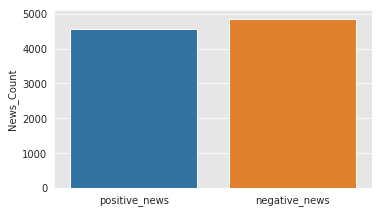

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.barplot(['positive_news','negative_news'], values)
plt.ylabel("News_Count")
plt.gcf().set_size_inches(5.7, 3.27)